In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math
from IPython.display import Image
import scipy.ndimage
import glob
import os

In [4]:
cd "/home/tushara/Documents/projects/phylab/elegans/data/exp1/trial2/complete_data/"

/home/tushara/Documents/projects/phylab/elegans/data/exp1/trial2/complete_data


In [5]:
reference_img = cv2.imread("/home/tushara/Documents/projects/phylab/elegans/data/exp1/trial2/complete_data/MA2_0001.JPG", 0)

worm1 = reference_img[1300:1600, 2200:2600]
worm2 = reference_img[1200:1600, 1550:1850]

# reference for worm 1
ret, bin_worm1 = (cv2.threshold(worm1, 110, 255, cv2.THRESH_BINARY))
bin_worm1 = np.uint8(~scipy.ndimage.binary_fill_holes(~bin_worm1))*255
worm1_contour, hierarchy = cv2.findContours(cv2.bitwise_not(bin_worm1), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE) 
worm1_area = cv2.contourArea(max(worm1_contour, key=cv2.contourArea))
worm1_length = len(max(worm1_contour, key=cv2.contourArea))

# reference for worm 2
ret, bin_worm2 = (cv2.threshold(worm2, 90, 255, cv2.THRESH_BINARY))
bin_worm2 = np.uint8(~scipy.ndimage.binary_fill_holes(~bin_worm2))*255
worm2_contour, hierarchy = cv2.findContours(cv2.bitwise_not(bin_worm2), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE) 
worm2_area = cv2.contourArea(max(worm2_contour, key=cv2.contourArea))
worm2_length = len(max(worm2_contour, key=cv2.contourArea))

In [27]:
def analysis(img):

    # note, all these separation of algorithm by image sets wont be necessary if the images have no difference
    if int(os.path.basename(path).split('_')[1].split('.')[0]) <= 1782: # this i have to do because two sets of data were collected separately and one set is zoomed in -- so the cropping has to be different
        cell = img[750:2350, 1500:3000] 

        cell_radius = 705
        cell_center = (720,805)
        mask = cv2.circle(np.zeros(cell.shape[:2],dtype=np.uint8), cell_center, cell_radius, (255,255,255), -1) # this creates an empty template of (255,255,255) (white) circle with outside parts as black.
        masked_cell = np.full_like(cell, 255) # this creates another template of full white
        masked_cell[mask!=0] = cell[mask!=0] # in the full white template, this then finds the region of the empty white circle and equates it to the same region of the cell image, giving image cropped with white outside
        
    else: # have to put the masking also inside because the magnification shifts the center of the masked cell
        cell = img[580:2500, 1375:3200] # just like before, i manually cropped the image to fit the cell perfectly
        
        cell_radius = 845 # to obtain this, i assumed that the two cells look the same, therefore the scaling of the dimensions of the cells must follow that of the radius and the center. 2350-750 = 1600; 3000-1500 = 1500; 3200-1375 = 1825; 2500-580 = 1920; 1920/1600 = 1.2; 1825/1500 = 1.22; avg(1.2,1.22)*old radius = new radius; (1.2*old center(x),1.22*old center(y)) = (new center(x), new center(y))
        cell_center = (860, 980) # had to shift around the radius and the center manually to avoid boundary being recognized for contour
        mask = cv2.circle(np.zeros(cell.shape[:2],dtype=np.uint8), cell_center, cell_radius, (255,255,255), -1) # this creates an empty template of (255,255,255) (white) circle with outside parts as black.
        masked_cell = np.full_like(cell, 255) # this creates another template of full white
        masked_cell[mask!=0] = cell[mask!=0] # in the full white template, this then finds the region of the empty white circle and equates it to the same region of the cell image, giving image cropped with white outside

    
    ret, bin_cell = (cv2.threshold(masked_cell, 90, 255, cv2.THRESH_BINARY))
    #cv2.bitwise_not(np.uint8(scipy.ndimage.binary_fill_holes(cv2.bitwise_not(bin_cell)))*255)
    
    # defining the contour
    contours, hierarchy = cv2.findContours(cv2.bitwise_not(bin_cell), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    
    single_worm_tolerance = 0.45
    merged_worm_tolerance = 0.30
    
    single_worm_min_area = np.average([worm1_area,worm2_area]) * (1-single_worm_tolerance) 
    single_worm_max_area = np.average([worm1_area,worm2_area]) * (1+single_worm_tolerance)
    
    merged_worm_min_area = (worm1_area+worm2_area)*(1-merged_worm_tolerance)
    merged_worm_max_area = (worm1_area+worm2_area)*(1+merged_worm_tolerance)
    
    worms_contour = [c for c in contours if (single_worm_min_area <= cv2.contourArea(c) <= single_worm_max_area or merged_worm_min_area <= cv2.contourArea(c) <= merged_worm_max_area) ]
    c_worms = cv2.cvtColor(bin_cell, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(c_worms, worms_contour, -1, (0, 255, 0), 2)

    # finding the distance 
    centers = []
    distance = np.nan
    lost_count = 0 # worms get lost when they outside the defined boundary of the cell
    if len(worms_contour) == 2:
        for i in range(len(worms_contour)):
            moments = cv2.moments(worms_contour[i])
            centers.append((int(moments['m10']/moments['m00']), int(moments['m01']/moments['m00'])))
            cv2.circle(c_worms, centers[-1], 10, (255, 0, 0), -1)
        distance = math.dist(centers[0], centers[1])

    elif len(worms_contour) == 1 and merged_worm_min_area <= cv2.contourArea(max(contours, key = cv2.contourArea)) <= merged_worm_max_area and cv2.arcLength(max(contours, key = cv2.contourArea), True) < 1350: # worm1_area+worm2_area because that's the correct value of range of area for when the two worms are merged; also the arc length so that the extra noise adding up the area doesn't interfere
        for i in range(len(worms_contour)):
            moments = cv2.moments(worms_contour[i])
            centers.append((int(moments['m10']/moments['m00']), int(moments['m01']/moments['m00'])))
            cv2.circle(c_worms, centers[-1], 10, (255, 0, 0), -1)
        distance = 0
        
    else:
        for i in range(len(worms_contour)):            
            if len(worms_contour[i]) > 250: # this because there are some background noises that get contoured and the worm distance is measured from this, so i write this to not assign a COM point to it so that distance is only measured between the two points visibl
                moments = cv2.moments(worms_contour[i])
                centers.append((int(moments['m10']/moments['m00']), int(moments['m01']/moments['m00'])))
                cv2.circle(c_worms, centers[-1], 10, (255, 0, 0), -1)
        if len(centers) > 1:
            distance = math.dist(centers[0], centers[1])
        else:
            distance = np.nan
            lost_count += 1

    return distance, centers, c_worms, cell, worms_contour, cell_radius, cell_center, lost_count, single_worm_min_area, single_worm_max_area, contours, merged_worm_min_area, merged_worm_max_area

[(327, 484)]


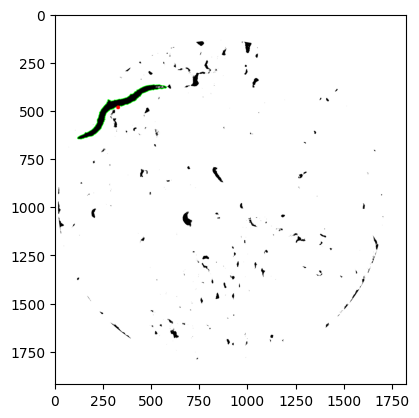

distance nan
1


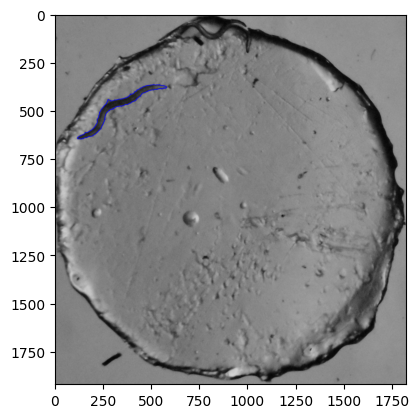

17122.0
1370.4204759597778
16495.149999999998 30633.850000000002
6480.2375 17084.2625


In [28]:
# only for tests
path = "/home/tushara/Documents/projects/phylab/elegans/data/exp1/trial2/complete_data/MA2_3445.JPG"
img = cv2.imread(path, 0)
print(analysis(img)[1])
plt.imshow(analysis(img)[2], cmap = "gray") # change the index to 1 and see what happens!!! -- i.e. if 1 corresponds to the returned centers value
plt.show()
print("distance", analysis(img)[0])
print(len(analysis(img)[4]))
contoured_cell = cv2.drawContours(cv2.cvtColor(analysis(img)[3], cv2.COLOR_GRAY2BGR), analysis(img)[4], -1, (0, 0, 255), 2)
plt.imshow(contoured_cell, cmap = "gray")
plt.show()
print(cv2.contourArea(max(analysis(img)[10], key = cv2.contourArea))) #23432.0 of 170
print(cv2.arcLength(max(analysis(img)[10], key = cv2.contourArea), True))
print(analysis(img)[11],analysis(img)[12])
print(analysis(img)[8],analysis(img)[9])

In [29]:
# this is to draw distance line b/w the worms and export the image
# this code only ouputs the images that have no lost worms

paths = sorted(glob.glob("*.JPG"))
for i, path in enumerate(paths):
    img = cv2.imread(path, 0)
    if img is not None:
        contoured_cell = cv2.drawContours(cv2.cvtColor(analysis(img)[3], cv2.COLOR_GRAY2BGR), analysis(img)[4], -1, (255, 0, 0), 2)
        for j in range(len(analysis(img)[4])):
            try: # not sure again why there is the error, so ignoring for now
                cv2.circle(contoured_cell, analysis(img)[1][j], 10, (0, 0, 255), -1)
            except IndexError:
                pass
        if len(analysis(img)[4]) == 2: # for when worms get lost, i can't draw the line.    
            if ~np.isnan(analysis(img)[0]):
                try: 
                    two_worms = cv2.line(contoured_cell, analysis(img)[1][0], analysis(img)[1][1], (255,255,255), 5)
                    text_worms = cv2.putText(two_worms, str(int(np.round(analysis(img)[0])))+"px", (int(np.round((analysis(img)[1][0][0]+analysis(img)[1][1][0])/2)), int(np.round((analysis(img)[1][0][1]+analysis(img)[1][1][1])/2))), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255),2,cv2.LINE_AA)
                    cv2.imwrite(os.path.join("/home/tushara/Documents/projects/phylab/elegans/analysis_code/images/new_worms_confined/", os.path.basename(path)), text_worms)
                except (ValueError, IndexError): # for some reason, the image 0013 is giving both these errors -- investigated separately and seems fine, not sure why this here is causing error
                    pass
            elif np.isnan(analysis(img)[0]):
                cv2.imwrite(os.path.join("/home/tushara/Documents/projects/phylab/elegans/analysis_code/images/new_worms_confined/", os.path.basename(path)), contoured_cell)
        
        elif len(analysis(img)[4]) == 1 and analysis(img)[11] <= cv2.contourArea(max(analysis(img)[10], key = cv2.contourArea)) <= analysis(img)[12]:
            if ~np.isnan(analysis(img)[0]):
                text_worms = cv2.putText(contoured_cell, str(int(np.round(analysis(img)[0])))+"px", (analysis(img)[1][0][0], analysis(img)[1][0][1]), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255),2,cv2.LINE_AA)
                cv2.imwrite(os.path.join("/home/tushara/Documents/projects/phylab/elegans/analysis_code/images/new_worms_confined/", os.path.basename(path)), text_worms)
            
            elif np.isnan(analysis(img)[0]):
                cv2.imwrite(os.path.join("/home/tushara/Documents/projects/phylab/elegans/analysis_code/images/new_worms_confined/", os.path.basename(path)), contoured_cell)    
        
        elif len(analysis(img)[4]) == 3:
            if ~np.isnan(analysis(img)[0]):
                try: 
                    two_worms = cv2.line(contoured_cell, analysis(img)[1][0], analysis(img)[1][1], (255,255,255), 5)
                    text_worms = cv2.putText(two_worms, str(int(np.round(analysis(img)[0])))+"px", (int(np.round((analysis(img)[1][0][0]+analysis(img)[1][1][0])/2)), int(np.round((analysis(img)[1][0][1]+analysis(img)[1][1][1])/2))), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255),2,cv2.LINE_AA)
                    cv2.imwrite(os.path.join("/home/tushara/Documents/projects/phylab/elegans/analysis_code/images/new_worms_confined/", os.path.basename(path)), text_worms)
                except (ValueError, IndexError): # for some reason, the image 0013 is giving both these errors -- investigated separately and seems fine, not sure why this here is causing error
                    pass
            elif np.isnan(analysis(img)[0]):
                cv2.imwrite(os.path.join("/home/tushara/Documents/projects/phylab/elegans/analysis_code/images/new_worms_confined/", os.path.basename(path)), contoured_cell)
        
            
        else:
            cv2.imwrite(os.path.join("/home/tushara/Documents/projects/phylab/elegans/analysis_code/images/new_worms_confined/", os.path.basename(path)), contoured_cell)
            
    if i % 100 == 0:
        print(f"Processed {i}/{len(paths)} frames ({i/len(paths)*100:.1f}%)")
print("done")

#to combine images into video: 
#ffmpeg -framerate 30 -pattern_type glob -i '*.png' -c:v libx264 -pix_fmt yuv420p out.mp4

Processed 0/188 frames (0.0%)
Processed 100/188 frames (53.2%)
done


In [33]:
fps = 30
paths = sorted(glob.glob("*.JPG"))
times = []
distances = []
for i, path in enumerate(paths):
    img = cv2.imread(path, 0)
    
    if img is None: # there are some corrupted images where I am putting NaN as the data
        times.append(i/fps)
        distances.append(np.nan)
        print("printed nan")
        continue
        
    times.append(i/fps)
    distances.append(analysis(img)[0] if analysis(img)[0] is not None else np.nan)
    
    if i % 100 == 0:
        print(f"Processed {i}/{len(paths)} frames ({i/len(paths)*100:.1f}%)")

Processed 0/3582 frames (0.0%)
Processed 100/3582 frames (2.8%)
Processed 200/3582 frames (5.6%)
Processed 300/3582 frames (8.4%)
Processed 400/3582 frames (11.2%)
Processed 500/3582 frames (14.0%)
printed nan
printed nan
Processed 600/3582 frames (16.8%)
Processed 700/3582 frames (19.5%)
Processed 800/3582 frames (22.3%)
Processed 900/3582 frames (25.1%)
Processed 1000/3582 frames (27.9%)
Processed 1100/3582 frames (30.7%)
printed nan
printed nan
Processed 1200/3582 frames (33.5%)
Processed 1300/3582 frames (36.3%)
printed nan
Processed 1400/3582 frames (39.1%)
Processed 1500/3582 frames (41.9%)
Processed 1600/3582 frames (44.7%)
Processed 1700/3582 frames (47.5%)
printed nan
Processed 1800/3582 frames (50.3%)
Processed 1900/3582 frames (53.0%)
Processed 2000/3582 frames (55.8%)
Processed 2100/3582 frames (58.6%)
Processed 2200/3582 frames (61.4%)
printed nan
Processed 2300/3582 frames (64.2%)
Processed 2400/3582 frames (67.0%)
Processed 2500/3582 frames (69.8%)
Processed 2600/3582 fr

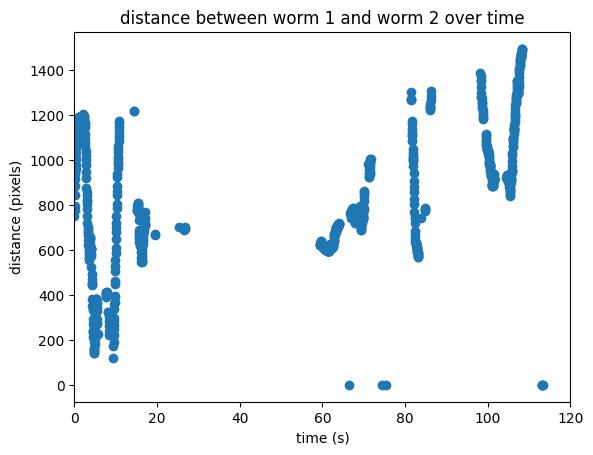

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

data_w = pd.DataFrame({"time": times, "distance": distances})
data_w.to_csv("/home/tushara/Documents/projects/phylab/elegans/analysis_code/analyzed_data/distance_over_time_confined.csv", index = False)

data_r = pd.read_csv("/home/tushara/Documents/projects/phylab/elegans/analysis_code/analyzed_data/distance_over_time_confined.csv", header=0)
ts = data_r.iloc[:,0].values
ds = data_r.iloc[:,1].values

plt.scatter(ts, ds)
plt.xlabel("time (s)")
plt.ylabel("distance (pixels)")
max_range = 120
plt.xlim(0, max_range)
plt.title("distance between worm 1 and worm 2 over time")
plt.savefig("/home/tushara/Documents/projects/phylab/elegans/analysis_code/images/120_dvt_confined.png")
plt.show()

In [35]:
'''# this code is to identify the last image that was used in the range given for the plotting
time = []
for i in ts:
    if i<max_range:
        time.append(i)

distance = []
for i in range(len(time)):
    distance.append(ds[i])

end_distance = 0
for j in distance[::-1]:
    if np.isnan(j) == False:
        end_distance += j
        break

end_time = ts[distance.index(end_distance)]
print(end_time, end_distance)'''

'# this code is to identify the last image that was used in the range given for the plotting\ntime = []\nfor i in ts:\n    if i<max_range:\n        time.append(i)\n\ndistance = []\nfor i in range(len(time)):\n    distance.append(ds[i])\n\nend_distance = 0\nfor j in distance[::-1]:\n    if np.isnan(j) == False:\n        end_distance += j\n        break\n\nend_time = ts[distance.index(end_distance)]\nprint(end_time, end_distance)'

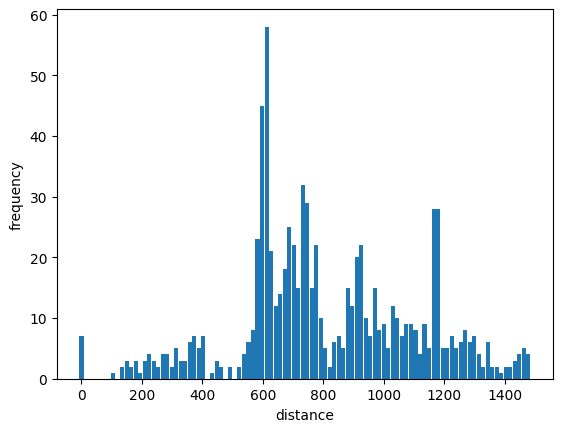

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

data_r = pd.read_csv("/home/tushara/Documents/projects/phylab/elegans/analysis_code/analyzed_data/distance_over_time_confined.csv", header=0)
ts = data_r.iloc[:,0].values
ds = data_r.iloc[:,1].values

plt.hist(ds, bins=100, align = "left", rwidth = 0.9)
plt.xlabel("distance")
plt.ylabel("frequency")
plt.savefig("/home/tushara/Documents/projects/phylab/elegans/analysis_code/images/hist_confined.png")
plt.show()

# Notes
Here, the worms outside the boundary (defined through cropping at some center and with some radius) are considered lost and are not considered in the analysis. Quantitatively, worms being lost is implied by the worms_contour count. If it's len(worms_contour) == 2, then both worms are inside, in which case the distance between them can be measured. If either one or both are outside, such that len(worms_contour) in (0,1), then the images are ignored.

- The histogram highlights the distance density, i.e. the probability of finding the worms at some distance
- The time series plot highlights the change in distance between the two worms over time
- The exported images have the distance, the contours, and the center of masses mapped.

Assumptions made: 
1. Two sets of data were collected separately with a time lag of some minutes between the collection. The second set had magnified images captured, for some reason, so I had manually crop to match the cropping of the first set. There are, therefore, errors.
2. If the worms are too close such that the area of one body becomes twice that of a single (+- tolerance) the distance is assumed to be zero. This has been included in the data. The output images of this cases cannot have lines though since there is just one worm. So, I mention 0 px.
    - i was thinking of also mentioning "lost" for when the distances are not measured. haven't done it yet though.
    - for some images, even though the distance b/w the two worms is zero, since they are around the boundary and some of their features are lost, the algorithm does not consider them to have large enough area of merged worms (+- tolerance) to be considered close and assign distance = 0. So, i am ignoring those data points for now. There are not many of them but still quite a few -- error to be accounted for!